<center><h2>Détection de thème sur une question environnement du grand débat</h2></center>

Fork du projet TALAGRAND disponible ici : https://github.com/Quantmetry/grand-debat. 
Dans mon implémentation, j'ai utilisé le même algo de LDA de scikit-learn, modifié la préparation de données, et déterminé le nombre de thèmes grâce un score de cohérence.

Mon but est d'essayer des techniques d'extraction de thème (topic detection) sur des questions du grand débat.
Pour cet essai j'ai pris : "de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?").  
Je l'ai comparé ensuite à la synthèse "officielle" réalisée par OpinionWay : 
https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf

In [1]:
import warnings; warnings.simplefilter('ignore')

# Téléchargement des données
-  Récupérer la liste des thèmes en analysant le site du Grand Débat
-  Sélectionner un thème en modifiant la variable `selected_theme`
-  Télécharger ensuite le fichier json le plus récent associé à un thème depuis datagouv.fr

In [2]:
from grand_debat.downloading import download_data, get_themes

#themes = get_themes() # not working

themes = {"1 L'organisation de l'État et des services publics": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/"+
              "2019-03-21/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.json",
          "2 la-transition-ecologique": 
              "http://opendata.auth-6f31f706db6f4a24b55f42a6a79c5086.storage.sbg.cloud.ovh.net/2019-03-21/"+
              "LA_TRANSITION_ECOLOGIQUE.json"
         }

In [3]:
# Choisir le numéro associé au thème que l'on souhaite étudier
selected_theme = 2

In [4]:
#download_data(themes, selected_theme)

# Chargement des données
-  Charger le fichier json précédemment téléchargé
-  Afficher les différentes questions associées au thème sélectionné
-  Sélectionner une question à étudier (variable `selected_question`)
-  Afficher le nombre de réponses existantes correspondant à cette question

In [5]:
from grand_debat.loading import load_data, load_question, get_path

In [6]:
path = get_path(themes, selected_theme)
data_theme_json = load_data(path)

In [7]:
questions_id = [r['questionId'] for r in data_theme_json[0]['responses']]
questions_title = [r['questionTitle'] for r in data_theme_json[0]['responses']]
for id, title in zip(questions_id, questions_title):
    print("ID : {} - Question: {}".format(id, title))
    print()

ID : UXVlc3Rpb246MTYw - Question: Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?

ID : UXVlc3Rpb246MTYx - Question: Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?

ID : UXVlc3Rpb246MTQ2 - Question: Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?

ID : UXVlc3Rpb246MTQ3 - Question: Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?

ID : UXVlc3Rpb246MTQ4 - Question: À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?

ID : UXVlc3Rpb246MTQ5 - Question: Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?

ID : UXVlc3Rpb246MTUw - Question: Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de tr

In [8]:
# Indiquer ici l'identifiant associé à la question étudiée
selected_question = 'UXVlc3Rpb246MTQ3' # Si oui, de quelle manière votre vie quotidienne est-elle touchée ...

In [9]:
selected_question = str(selected_question)
data_theme_response_dict = load_question(questions_id, data_theme_json, selected_question)
print("Nombre de réponses analysées :", len(data_theme_response_dict[selected_question]))

Nombre de réponses analysées : 92792


In [10]:
import pandas as pd
def inspect_responses(data_theme_json, selected_question):
    resp_flat = pd.DataFrame.from_records(
        pd.json_normalize(data_theme_json[:10])["responses"].explode().values)
    return resp_flat.loc[resp_flat["questionId"] == selected_question, "value"].dropna()

list(inspect_responses(data_theme_json, selected_question))

["Pollution de l'air, pollution de nos aliments, maladie chronique dans mon entourage, maladie digestive",
 "Réchauffement climatique évident , températures en hausse permanente et changements brutaux d'un point de vue météo avec trés gros orages . La question est mal posée à mon avis .",
 'Climat',
 "la qualité de l'air n'est pas la même selon la météo"]

## <h2>Détection de thèmes</h2>
-  Détecter les thèmes principaux associés à la question sélectionnée en utilisant l'algorithme **LDA** (Latent Dirichlet Allocation)
-  Le resultat de l'analyse se trouve dans le fichier pyLDAVIS_tf.html

In [11]:
from tqdm import tqdm
import importlib
import grand_debat.theme_detection as td
importlib.reload(td)

/Users/charlesprat/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


<module 'grand_debat.theme_detection' from '/Users/charlesprat/RepoGit/grand-debat/grand_debat/theme_detection.py'>

### Preparation des données

Tokenisation, lemmatisation, filtrage sur type (POS NOUN et ADJ) et stop words de spacy

In [12]:
# spacy preparation
import spacy
nlp = spacy.load("fr_core_news_md")

In [13]:
answ_lems = td.lemmatize_answers(data_theme_response_dict[selected_question], nlp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92792/92792 [02:16<00:00, 677.94it/s]


### Recherche du nombre optimal de thèmes pour l'entrée de la LDA

On se base sur le "coherence score".  
https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [30]:
from numpy.random import default_rng
rng = default_rng(seed=333)

num_topics = [3,4,5,6,7,10,12]
answs_samples = rng.choice(answ_lems, size=20000, replace=False).tolist()
v_coh, l_topics, best_n = td.compute_coherence_vs_ntopics(answs_samples, num_topics=num_topics, 
                                     stop_words=nlp.Defaults.stop_words, lambda_coh=0.3)

compute lda for 3 topics
compute lda for 4 topics
compute lda for 5 topics
compute lda for 6 topics
compute lda for 7 topics
compute lda for 10 topics
compute lda for 12 topics
Best coherence achieved for n_topics = 5


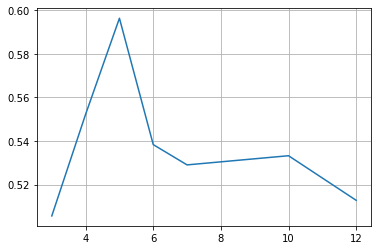

In [43]:
import matplotlib.pyplot as plt
f,ax = plt.subplots()

pd.Series(v_coh, index=[len(topic) for topic in l_topics]).plot(ax=ax)
ax.grid()
#ax.set_ylim(0.2,0.7)

### LDA sur l'ensemble des donnée

In [37]:
# Plusieurs essais random me montrent que sur la question sélectionnée UXVlc3Rpb246MTQ3
# le premier maximum de la coherence se trouve entre 5 et 6. 

n_topics = 6

In [38]:
tf_vectorizer, lda_tf = td.get_themes(answ_lems, n_topics=n_topics, stop_words=nlp.Defaults.stop_words)

print("Les différents thèmes associés à la question se situent dans le fichier pyLDAVIS_tf.html")

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100, perplexity: 740.7483
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100, perplexity: 678.9031
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100, perplexity: 661.2966
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100, perplexity: 653.0879
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 649.4094
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100, perplexity: 647.5425
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100, perplexi

In [53]:
lambda_rel = 0
topics = [] 
for ii in range(lda_tf.components_.shape[0]):
    topic = td.get_topic_by_relevance(tf_vectorizer, lda_tf, lambd=lambda_rel, n_topic=ii).tolist()
    print(topic)
    topics.append(topic)

['tempête', 'violent', 'phénomène', 'météo', 'extrême', 'inondation', 'crue', 'orage', 'météorologique']
['été', 'hiver', 'chaud', 'neige', 'froid', 'montagne', 'doux', 'février', 'sec']
['quotidien', 'avenir', 'planète', 'voiture', 'transport', 'question', 'futur', 'inquiétude', 'conscience']
['dérèglement', 'modification', 'littoral', 'érosion', 'prix', 'fruit', 'agricole', 'légume', 'assurance']
['disparition', 'insecte', 'oiseau', 'espèce', 'animal', 'abeille', 'faune', 'campagne', 'flore']
['air', 'pollution', 'allergie', 'respiratoire', 'pic', 'asthme', 'atmosphérique', 'cancer', 'particule']


### Interprétation

L'application du LDA donnent les thèmes suivants:  

['tempête', 'violent', 'phénomène', 'météo', 'extrême', 'inondation', 'crue', 'orage', 'météorologique']  
['été', 'hiver', 'chaud', 'neige', 'froid', 'montagne', 'doux', 'février', 'sec']  
['quotidien', 'avenir', 'planète', 'voiture', 'transport', 'question', 'futur', 'inquiétude', 'conscience']  
['dérèglement', 'modification', 'littoral', 'érosion', 'prix', 'fruit', 'agricole', 'légume', 'assurance']  
['disparition', 'insecte', 'oiseau', 'espèce', 'animal', 'abeille', 'faune', 'campagne', 'flore']  
['air', 'pollution', 'allergie', 'respiratoire', 'pic', 'asthme', 'atmosphérique', 'cancer', 'particule']  

J'interprête chacun comme cela :

["Événements extrêmes", "Réchauffement / saisons", "Inquiétude pour les\ngénérations futures",
               "Alimentation / agriculture", "Biodiversité", "Pollution de l'air"]

Text(0.5, 1.0, 'Pourcentage des réponses mentionant un thème')

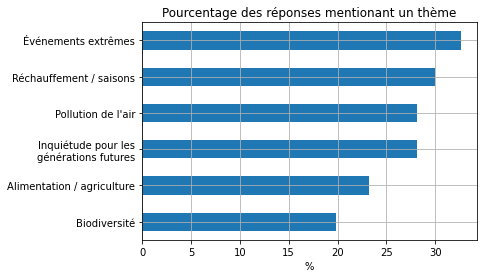

In [119]:
topic_names = ["Événements extrêmes", "Réchauffement / saisons", "Inquiétude pour les\ngénérations futures",
               "Alimentation / agriculture", "Biodiversité", "Pollution de l'air"]
topics_pct = pd.Series(index=topic_names, 
                       data=(lda_tf.transform(tf_vectorizer.transform(answ_lems)) >0.2).mean(axis=0)*100)

f,ax = plt.subplots()
topics_pct.sort_values().plot(kind="barh")
ax.grid()
ax.set_xlabel("%")
ax.set_title("Pourcentage des réponses mentionant un thème")

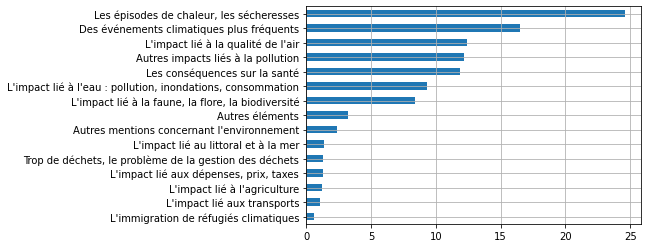

In [102]:
# topics OpinionWay 
# https://granddebat.fr/media/default/0001/01/b88758e8caa2733bec607a74b3b5371cc0a3b420.pdf 
topics_ow = pd.Series(
    {"Les épisodes de chaleur, les sécheresses": 24.6,
    "Des événements climatiques plus fréquents": 16.5,
    "L'impact lié à la qualité de l'air": 12.4,
    "Autres impacts liés à la pollution": 12.2,
    "L'impact lié à l'eau : pollution, inondations, consommation": 9.3,
    "Les conséquences sur la santé": 11.9,
     "L'impact lié à la faune, la flore, la biodiversité": 8.4,
     "Autres éléments": 3.2,
     "Autres mentions concernant l'environnement": 2.4,
     "L'impact lié au littoral et à la mer": 1.4,
     "L'impact lié aux dépenses, prix, taxes": 1.3,
     "Trop de déchets, le problème de la gestion des déchets": 1.3,
     "L'impact lié à l'agriculture": 1.2,
     "L'impact lié aux transports": 1.1,
     "L'immigration de réfugiés climatiques": 0.6
    }
)

f,ax = plt.subplots()
topics_ow.sort_values().plot(kind="barh",ax=ax)
ax.grid()



<h2>Résumé de chaque thème</h2>
-  Résumer un grand thème en utilisant TextRank, technique de résumé extractive
-  Spécifier le nombre de phrases que l'on souhaite pour former le résumé dans la variable `sn`
-  Les résultats se situent dans le fichier demo.docx

In [120]:
from grand_debat.text_summarization import prepare_data, apply_page_rank_algorithm, create_titles
from grand_debat.vectorization import sentence_to_vec
from grand_debat.clusterisation import apply_clusterisation

In [121]:
#import nltk
#nltk.download('punkt')

Transformer le document texte en un ensemble de phrases dont la typographie est standardisée

In [122]:
clean_sentences = prepare_data(data_theme_response_dict, selected_question)

Récupérer la phrase la plus caractéristique de chaque thème

In [123]:
sentences_mixture_topics, title_sentences, titles = create_titles(clean_sentences, tf_vectorizer, lda_tf)

multiplication des épisodes pluvieux de type méditerranéens, amplification des phénomènes météo (vent tempétueux, sécheresse sévère plus fréquente,...) 

dans le var où j'habite : pluies presqu'incessantes l'an dernier jusqu'en juin et donc quantité de moustiques sans précédent l'été dernier, températures presque estivales en plein mois de décembre et encore en ce moment ! 

arrêt quasiment complet d'achats de vêtements / d'objets, mode de vie zéro déchet, compostage, utilisation de la voiture en dernier recours, arrêt des trajets en avion, réduction de la consommation de viande, sobriété énergétique 

la tension pour l'accès à la ressource en eau, la compétition entre production agricole pour l'exportation et la production agricole pour l'alimentation 

par la disparition d'une certaine faune sauvage ( hirondelles, chauve-souris, rapaces nocturnes, abeilles ... ) , par la prolifération d'espèces animales invasives ( moustique tigre , frelon asiatique, coccinelles). 

je suis asthmatiq

Associer à chaque phrase du corpus son thème (issu de **LDA**) le plus carctéristique

In [ ]:
sentences_paragraph = apply_clusterisation(sentences_mixture_topics)

Représenter chaque phrase sous la forme d'un vecteur dense. Ces vecteurs sont obtenus à partir d'embeddings entraînés à partir de l'ensemble des contributions au Grand Débat

In [ ]:
sentence_vectors, word_embeddings = sentence_to_vec(clean_sentences, file_model='data/word2vec.10k.100d.txt')

On applique alors l'algorithme **TextRank** à l'ensemble des phrases d'un thème pour en extraire les phrases carctéristiques

In [ ]:
# Indiquer le nombre de phrases qui formeront le résumé
sn = 10
apply_page_rank_algorithm(clean_sentences, sentences_paragraph, word_embeddings, sn)

## Export de la synthèse sous la forme d'un document word
-  Créer le document final contenant les résumés pour chaque thème de la question.
-  Le processus prend environ 20 minutes sur une machine équipée d'un intel core i5.

In [ ]:
from grand_debat.saving import create_final_doc, get_theme, get_question

In [ ]:
theme_sentence = get_theme(themes, selected_theme)
question_sentence = get_question(questions_id, questions_title, selected_question)
create_final_doc(title_sentences, titles, clean_sentences,
                 sentences_paragraph, word_embeddings, theme_sentence, question_sentence)